In [1]:
SEED_NUMBER = 1234
from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed
seed(SEED_NUMBER)
set_random_seed(SEED_NUMBER)

import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

pd.options.display.max_columns=500
pd.options.display.max_rows=500

# load preprocessed datasets
train = pd.read_csv('./data/processed/train_processed.csv')  
test = pd.read_csv('./data/processed/test_processed.csv') 

#### Preprocess: 
See task/process_data.py and Data Processing README.rmd for detailed documentation.
- remove outliers
- impute missing values
- add new features
- dummify categorical features
- bucketize numeric features and dummified

In [2]:
print(train.shape)
print(train.isnull().sum().sum()) # check for no missing value
train.head() # visually inspect dataset. 

(1456, 258)
0


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,IsPool,IsGarage,IsFireplace,TotalFullBath,TotalHalfBath,TotalSF,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,7,5,196.0,8,6,8,6,10,706,0,150,856,10,856,854,0,1710,1,0,2,1,3,1,8,8,0,0,2003.0,4,2,548,6,6,0,61,0,0,0,0,0,208500,0,1,1,3,1,2566,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

<b>Train test split

In [3]:
np.random.seed(SEED_NUMBER)
msk = np.random.rand(train.shape[0]) < 0.75
traindf = train[msk]
testdf = train[~msk]
train_labels = traindf.pop('SalePrice')
test_labels = testdf.pop('SalePrice')
print(f'training shape: {traindf.shape} and test shape: {testdf.shape}')

training shape: (1081, 257) and test shape: (375, 257)


<b> Standard Scaler</b>
<br>
Scaling numeric features helps with model in general.
This is proven to improve neural networks model performance.

In [4]:
# numeric columns where values range beyond -1 to 1.
SCALE_COLS = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'GarageYrBlt', 'OpenPorchSF', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'TotalFullBath', 'TotalHalfBath', 'TotalSF', 'HeatingQC','BsmtFinType1']


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # default : copy=True, with_mean=True, with_std=True
scaler.fit(traindf[SCALE_COLS]) # we can save scaler if need to be reused in the future or build it into our data preprocessing pipeline.

# transform
traindf_s = pd.DataFrame(scaler.transform(traindf[SCALE_COLS]), columns = SCALE_COLS)
traindf_s = pd.concat([traindf.drop(columns=SCALE_COLS).reset_index(drop=True),traindf_s],axis=1)
testdf_s = pd.DataFrame(scaler.transform(testdf[SCALE_COLS]), columns = SCALE_COLS)
testdf_s = pd.concat([testdf.drop(columns=SCALE_COLS).reset_index(drop=True),testdf_s], axis=1)

print(f'training shape: {traindf_s.shape} and test shape: {testdf.shape}')
testdf_s.head() # check that scaler worked.

training shape: (1081, 257) and test shape: (375, 257)


,IsPool,IsGarage,IsFireplace,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageYrBlt,OpenPorchSF,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalFullBath,TotalHalfBath,TotalSF,HeatingQC,BsmtFinType1
0,0,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

<b>Benchmark model</b>
<br>Establishing a simple linear model with L1 regularization as our benchmark model to compare our neural net models against.

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
for a in [0.00003, 0.0003, 0.003, 0.03, 0.3, 3, 33, 333, 3333, 33333]:
    linear_estimator = Lasso(alpha = a)
    score = cross_val_score(linear_estimator, traindf_s, train_labels, \
                            scoring= 'neg_root_mean_squared_error', cv = 3) # 3 fold cross validation 
    print(f'Alpha: {a}  --- mean RMSE: {round(np.mean(-score),4)} std: {round(np.std(-score),4)}')

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194691919114.07233, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183201861464.2257, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189441989940.4667, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

Alpha: 3e-05  --- mean RMSE: 31709.3835 std: 1356.3262
Alpha: 0.0003  --- mean RMSE: 31709.8354 std: 1356.7409


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183186025291.32217, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189407217171.74536, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194448284884.31155, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

Alpha: 0.003  --- mean RMSE: 31714.938 std: 1361.7529
Alpha: 0.03  --- mean RMSE: 31767.1137 std: 1417.4161


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170582349382.21222, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164969422053.10562, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153250415392.80536, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

Alpha: 0.3  --- mean RMSE: 31728.4856 std: 1383.6079
Alpha: 3  --- mean RMSE: 31237.2559 std: 973.2761


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56391862118.00305, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59191555985.85486, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3202099888.1324463, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

Alpha: 33  --- mean RMSE: 30315.0685 std: 659.414
Alpha: 333  --- mean RMSE: 28814.0156 std: 1339.0096
Alpha: 3333  --- mean RMSE: 29941.8992 std: 1910.5316
Alpha: 33333  --- mean RMSE: 50894.6563 std: 2349.7919


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6530617354.721619, tolerance: 428250184.11820865
  positive)


<b> Benchmark model: LASSO w/ alpha = 333. </b>
- Cross Valiation mean RMSE: 28814.0156 std: 1007.3058 <br>
- this is a big penalization for large coefficients. Let's see how the lasso model performs on our test dataset.

In [6]:
def test_rmse(test_predictions):
# Generate mean test error rmse.
    rmse = np.mean(np.sqrt((test_labels - test_predictions)**2))
    print(f'***** Test RMSE: {rmse} *****')

In [7]:
linear_estimator = Lasso(alpha = 333)
linear_estimator.fit(traindf_s, train_labels)
test_rmse(linear_estimator.predict(testdf_s))

***** Test RMSE: 20431.374067946865 *****


## Neural Network - Keras

Starting from the simplest, let's start with basic nn with only 1 hidden unit.
<br>
X --> 257 (Relu) --> Y, dim(X) = [1081, 257]
<br>
optimizers: 
- keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
- keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 2000
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) # plot the train error and validation error.


In [9]:
def plot_errors(test_predictions, title):
    ### plot error distribution
    ### input : predicted values, title of plots.
    ### output: 2 plots: true value vs prediction value, error distribution
    error = test_labels - test_predictions
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].scatter(test_labels, test_predictions) # plot true vs predicted values
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    
    axs[1].hist(error, bins = 40) # error distribution
    axs[1].set_xlabel('Test Prediction Error')
    fig.suptitle(title)

In [10]:
def build_basic_model(optimizer = keras.optimizers.RMSprop(0.01), dropout=False, rate = 0.1):
    
# build a basic neural net model: X--> 257 --> Y
#     input: 
#         optimizer: keras optimizer. default: RMSprop
#         dropout: True or False
#         rate: dropout rate. ranges between 0 and 1. default is 0.1
#     output:
#         basic neural net model.
    
    set_random_seed(SEED_NUMBER) # reproducibility
    
    model = keras.Sequential()
    model.add(layers.Dense(len(traindf_s.keys()), activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        model.add(layers.Dropout(rate, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

In [11]:
model = build_basic_model() # build model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               66306     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()

# train model
history = model.fit(traindf_s, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    verbose=0, shuffle = False,
                    callbacks=[tfdocs.modeling.EpochDots()])
print('\n')
print('TRAIN TIME:'+f'{round(time.time()-start_time)} seconds')
hist = pd.DataFrame(history.history) # training history
hist['epoch'] = history.epoch
hist.tail() # check last few epoch training data.


Epoch: 0, loss:37550431725.0370,  root_mean_squared_error:193779.3438,  val_loss:41121499220.9401,  val_root_mean_squared_error:202784.3750,  
....................................................................................................
Epoch: 100, loss:534764861.0370,  root_mean_squared_error:23124.9844,  val_loss:1268635069.9355,  val_root_mean_squared_error:35617.9023,  
....................................................................................................
Epoch: 200, loss:416251282.9630,  root_mean_squared_error:20402.2383,  val_loss:1051927621.6037,  val_root_mean_squared_error:32433.4355,  
....................................................................................................
Epoch: 300, loss:349561174.5185,  root_mean_squared_error:18696.5547,  val_loss:996360985.9539,  val_root_mean_squared_error:31565.1855,  
....................................................................................................
Epoch: 400, loss:313606395.2593, 

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
1995,1.156432e+08,10753.753906,1.111744e+09,33342.820312,1995
1996,1.155352e+08,10748.730469,1.111819e+09,33343.949219,1996
1997,1.154173e+08,10743.246094,1.112091e+09,33348.035156,1997
1998,1.152910e+08,10737.366211,1.111873e+09,33344.753906,1998
1999,1.151633e+08,10731.416016,1.111889e+09,33345.003906,1999


Text(0, 0.5, 'RMSE')

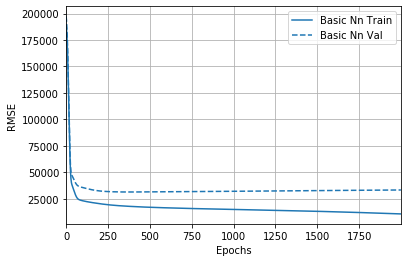

In [13]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) # plotting training progress history
plotter.plot({'Basic NN': history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

As you see from above, simple neural net is already performing better than the fine tuned lasso model.
However, the validation error is not decreasing while training error is.
<br>
Training 2000 epochs takes a lot of time especially if we have more data and it is not necessarily beneficial.
we can either tweak number of epoches or use early stopping.
Let's try using early stopping to stop training when validation error stops decreasing.

### Adding Early Stopping

X --> 257 (Relu) --> Y


Epoch: 0, loss:37550431725.0370,  root_mean_squared_error:193779.3438,  val_loss:41121497578.7650,  val_root_mean_squared_error:202784.3750,  
....................................................................................................
Epoch: 100, loss:534764861.0370,  root_mean_squared_error:23124.9844,  val_loss:1268635045.1613,  val_root_mean_squared_error:35617.9023,  
....................................................................................................
Epoch: 200, loss:416251282.9630,  root_mean_squared_error:20402.2383,  val_loss:1051927631.0415,  val_root_mean_squared_error:32433.4336,  
....................................................................................................
Epoch: 300, loss:349561174.5185,  root_mean_squared_error:18696.5547,  val_loss:996360911.6313,  val_root_mean_squared_error:31565.1855,  
.................................................................................

TRAIN TIME:39 seconds 



Text(0, 0.5, 'RMSE')

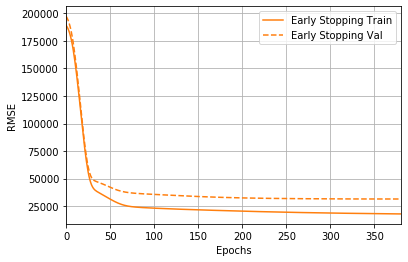

In [14]:
model = build_basic_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()

# train
early_history = model.fit(traindf_s, train_labels, shuffle = False, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n')
print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
plotter.plot({'Early Stopping': early_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

# Save Model
# model.save('simple_nn_w_early_stop.h5')

- So adding early stopping help our model train fast and also improved our result in the test set.

### Learning rate
let's try other learning rate to see if see if we can furture improve basic neural net


Epoch: 0, loss:37649445774.2222,  root_mean_squared_error:194034.6562,  val_loss:41393988508.9032,  val_root_mean_squared_error:203455.1250,  
....................................................................................................
Epoch: 100, loss:28810274664.2963,  root_mean_squared_error:169735.8906,  val_loss:31864167749.6037,  val_root_mean_squared_error:178505.3750,  
....................................................................................................
Epoch: 200, loss:10907864329.4815,  root_mean_squared_error:104440.7188,  val_loss:12486441271.4470,  val_root_mean_squared_error:111742.7422,  
....................................................................................................
Epoch: 300, loss:1999156015.4074,  root_mean_squared_error:44711.9219,  val_loss:2556302780.7558,  val_root_mean_squared_error:50559.8945,  
....................................................................................................
Epoch: 400, loss:1467

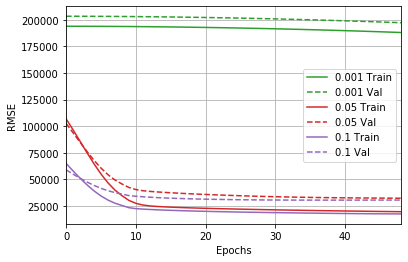

In [15]:
for lr in [0.001, 0.05, 0.1]:
    model = build_basic_model(keras.optimizers.RMSprop(lr))

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    set_random_seed(SEED_NUMBER) # reproducibility
    start_time = time.time()
    early_history = model.fit(traindf_s, train_labels, shuffle = False, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print(f'RMSprop learning rate: {lr} \n')
    print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
    plotter.plot({str(lr): early_history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')


- 0.001 converges too slow and training takes very long
- 0.05 and 0.1 are not as good as 0.01 for our dataset.
<br> Let's try another popular optimizer, Adam

<b>Adam optimizer</b>


Epoch: 0, loss:37650378676.1481,  root_mean_squared_error:194037.0625,  val_loss:41395652617.4378,  val_root_mean_squared_error:203459.2188,  
....................................................................................................
Epoch: 100, loss:21902414810.0741,  root_mean_squared_error:147994.6406,  val_loss:24368685905.4009,  val_root_mean_squared_error:156104.7344,  
....................................................................................................
Epoch: 200, loss:5665881106.9630,  root_mean_squared_error:75272.0469,  val_loss:6650502358.7097,  val_root_mean_squared_error:81550.6094,  
....................................................................................................
Epoch: 300, loss:1791316394.6667,  root_mean_squared_error:42323.9453,  val_loss:2395881066.1751,  val_root_mean_squared_error:48947.7383,  
....................................................................................................
Epoch: 400, loss:14017318

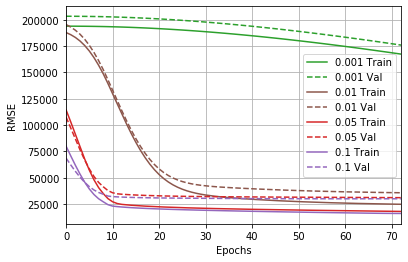

In [16]:
for lr in [0.001, 0.01, 0.05, 0.1]:
    model = build_basic_model(optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False))

   # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    set_random_seed(SEED_NUMBER) # reproducibility
    start_time = time.time()
    early_history = model.fit(traindf_s, train_labels, shuffle = False, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print(f'ADAM learning rate: {lr} \n')
    print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
    plotter.plot({str(lr): early_history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')

    # predict
    test_predictions = model.predict(testdf_s).flatten()
    print('\n')
    test_rmse(test_predictions) # print test set rmse.

- For our dataset, RMSprop with 0.01 learning rate is preforming better for the basic neural net.

<br>Next, let's try setting the hidden layer neuron bigger and small to see if that help our model perform better.

### Narrower/Wider Models
Recall our basic nn model (X -> 257 -> Y). Let's try other number of neurons other than 257.
<br>
Based on research, good rule of thumbs for N are: 2, (257 + 1)/ 2=129, we can also try some other numbers, 10, 50, 80, 160, 320, 500.
<br>50 has the best test_prediction rmse, with Mean Test RMSE: 16935.932416

In [17]:
def build_wider_model(N, optimizer = keras.optimizers.RMSprop(0.01), 
                      dropout = False, rate = 0.15):
# inputs: 
#     N: number of neurons for the hidden layer.
#     optimizer: default: RMSprop
#     dropout: True or False (it makes sense to try dropout on the wider model.)
#     rate: default - 0.15
    set_random_seed(SEED_NUMBER) # reproducibility

    model = keras.Sequential()
    model.add(layers.Dense(N, activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        model.add(layers.Dropout(rate, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model


Epoch: 0, loss:37651519488.0000,  root_mean_squared_error:194039.9844,  val_loss:41398480556.2396,  val_root_mean_squared_error:203466.1719,  
....................................................................................................
Epoch: 100, loss:37641868250.0741,  root_mean_squared_error:194015.1250,  val_loss:41388620615.9631,  val_root_mean_squared_error:203441.9219,  
....................................................................................................
Epoch: 200, loss:37632236961.1852,  root_mean_squared_error:193990.2969,  val_loss:41378767395.3917,  val_root_mean_squared_error:203417.7188,  
....................................................................................................
Epoch: 300, loss:37622607341.0370,  root_mean_squared_error:193965.4844,  val_loss:41368911872.0000,  val_root_mean_squared_error:203393.4844,  
....................................................................................................
Epoch: 400, loss:

....................................................................................................
Epoch: 1100, loss:531898724.7407,  root_mean_squared_error:23062.9277,  val_loss:1293814340.4240,  val_root_mean_squared_error:35969.6289,  
....................................................................................................
Epoch: 1200, loss:527201151.4074,  root_mean_squared_error:22960.8613,  val_loss:1284265103.9263,  val_root_mean_squared_error:35836.6445,  
....................................................................................................
Epoch: 1300, loss:522027584.0000,  root_mean_squared_error:22847.9258,  val_loss:1274105228.0922,  val_root_mean_squared_error:35694.6094,  
....................................................................................................
Epoch: 1400, loss:517373806.8148,  root_mean_squared_error:22745.8535,  val_loss:1265393252.4240,  val_root_mean_squared_error:35572.3672,  
................................



***** Test RMSE: 16989.4494375 *****

Epoch: 0, loss:37598120997.9259,  root_mean_squared_error:193902.3438,  val_loss:41257194491.2811,  val_root_mean_squared_error:203118.6719,  
....................................................................................................
Epoch: 100, loss:696209640.2963,  root_mean_squared_error:26385.7871,  val_loss:1461646898.7281,  val_root_mean_squared_error:38231.4922,  
....................................................................................................
Epoch: 200, loss:489253774.2222,  root_mean_squared_error:22119.0801,  val_loss:1188178709.5300,  val_root_mean_squared_error:34469.9688,  
....................................................................................................
Epoch: 300, loss:422617566.8148,  root_mean_squared_error:20557.6641,  val_loss:1068134330.9862,  val_root_mean_squared_error:32682.3242,  
..............................................................................................

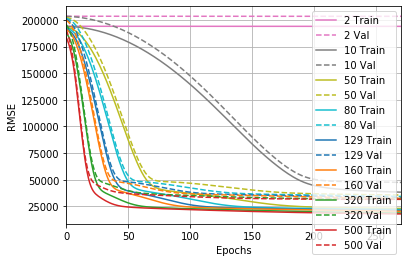

In [18]:
for N in [2, 10, 50, 80, 129, 160, 320, 500]:
    model = build_wider_model(N=N)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

    set_random_seed(SEED_NUMBER) # reproducibility

    start_time=time.time() # record training time
    model_history = model.fit(traindf_s, train_labels, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=False,
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print('- '*40)
    print(f'Neuron size: {N} \n')
    print('TRAIN TIME: '+f'{round(time.time()-start_time)}'+' seconds \n')
    plotter.plot({str(N): model_history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')

    test_predictions = model.predict(testdf_s).flatten()
    print('\n')
    test_rmse(test_predictions)
    # plot_errors(test_predictions, title='Neuron size '+str(N))

Number of neurons = 50 gives us the best Test RMSE 16934.

So far we've only built simple NN with 1 hidden layer.
<br>
Let's try deeper NN with more hidden layers to see if they perform better than the simple NN.

### Deeper Models
X -> N -> N -> N -> Y

In [29]:
def build_deeper_model(L, N, optimizer = keras.optimizers.RMSprop(0.01),
                       dropout = False, rate = 0.15):
    
#     inputs: 
#         L: integer, number of hidden layers.
#         N: list (integer), list of neurons in each hidden layers. len(N) == L
#         dropout: True or False, model will only drop node in layers where number of neuron is >= 50.
#         rate: float. Dropout rate. ranges between 0 to 1.

    
    # check inputs
    if len(N) != L:
        raise ValueError('length of N is not equal to L')
        
    set_random_seed(SEED_NUMBER) # reproducibility
    model = keras.Sequential()
    model.add(layers.Dense(N[0], activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        if N[0]>=50:
            model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    for i in range(1,L): # first layer is already added
        model.add(layers.Dense(N[i], activation='relu'))
        if dropout: 
            if N[i]>=50:
                model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    model.add(layers.Dense(1)) # final layer
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 500)               129000    
_________________________________________________________________
dense_149 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, loss:37467433756.4444,  root_mean_squared_error:193565.0625,  val_loss:40753059773.9355,  val_root_mean_squared_error:201873.8750,  
....................................................................................................
Epoch: 100, loss:364360740.8333,  root_mean_squared_error:19088.2363,  val_loss:1001875438.1567,  val_root_mean_squared_error:3


Epoch: 0, loss:11596264251.5556,  root_mean_squared_error:107685.9375,  val_loss:1627495815.0783,  val_root_mean_squared_error:40342.2344,  
.................

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
hidden layers: 4, number of neurons:[256, 128, 64, 32] 

TRAIN TIME:4 seconds 

375/375 - 0s - loss: 956492431.3600 - root_mean_squared_error: 30927.2129
Validation set Root Mean Squared Error: 30927.21


***** Test RMSE: 23368.5710625 *****
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 10)                2580      
_________________________________________________________________
dense_169 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_170 (Dense)            (None, 10)                110       
_______________________________

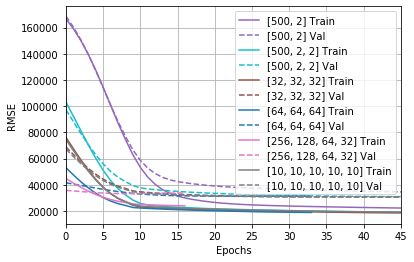

In [30]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]

for L, N in zip(try_hidden_layers,try_neuron_size):
    model = build_deeper_model(L, N)
    print(model.summary())
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)
    set_random_seed(SEED_NUMBER) # reproducibility
    start_time = time.time()
    model_history = model.fit(traindf_s, train_labels, shuffle = False,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 30, #default is 32
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print('- '*40)
    print(f'hidden layers: {L}, number of neurons:{N} \n')
    print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
    loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
    print("Validation set Root Mean Squared Error: {:5.2f}".format(rmse))

    plotter.plot({str(N): model_history}, metric = "root_mean_squared_error") 
    plt.ylabel('RMSE')

    test_predictions = model.predict(testdf_s).flatten() # predict
    print('\n')
    test_rmse(test_predictions)
    #plot_errors(test_predictions, title = 'Deep NN w/ early stopping')

### Deep NN w/ dropout
dropout is helpful regularization method for deeper neural nets that helps with overfitting problem.

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 500)               129000    
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, loss:37467359303.1111,  root_mean_squared_error:193564.8594,  val_loss:40752241479.9631,  val_root_mean_squared_error:201871.8438,  
................................................................................................



***** Test RMSE: 17320.6370625 *****
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 256)               66048     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_114 (Den

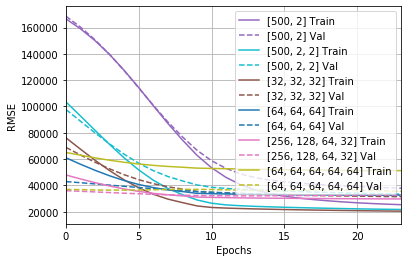

In [27]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32], [64,64,64,64,64]]

for L, N in zip(try_hidden_layers,try_neuron_size):
    model = build_deeper_model(L, N, dropout = True, rate = 0.1)
    print(model.summary())
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)
    set_random_seed(SEED_NUMBER) # reproducibility
    start_time = time.time()
    model_history = model.fit(traindf_s, train_labels, shuffle = False,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 30, #default is 32
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print('- '*40)
    print(f'hidden layers: {L}, number of neurons:{N} \n')
    print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
    loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
    print("Validation set Root Mean Squared Error: {:5.2f}".format(rmse))

    plotter.plot({str(N): model_history}, metric = "root_mean_squared_error") 
    plt.ylabel('RMSE')

    test_predictions = model.predict(testdf_s).flatten() # predict
    print('\n')
    test_rmse(test_predictions)
    #plot_errors(test_predictions, title = 'Deep NN w/ early stopping')